In [2]:
# Imports
import numpy as np
import pandas as pd
# import dcMinMaxFunctions as dc
# import dcor
from scipy.misc import derivative
from sklearn.model_selection import train_test_split
import math
import torch

In [3]:
df=pd.read_csv("data/Churn_Modelling.csv")

In [4]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [5]:
df=pd.read_csv("data/Churn_Modelling.csv")
# df=df.drop(['duration', 'pdays'],axis=1) # duration gives away the answer, and pdays has too much missing info

X = df.loc[:, df.columns != 'Exited'].replace(dict(yes=True, no=False))
Y = df.loc[:, ['Exited']].replace(dict(yes=True, no=False))

In [6]:
categorical_columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
outputs = ['Exited']

In [7]:
for category in categorical_columns:
    df[category] = df[category].astype('category')

In [8]:
def OHE(x):
    dim = max(x)
    y = np.zeros((len(x),dim+1))
    for i in range(len(x)):
        y[i][x[i]] = 1
    return(y)

In [9]:
geo = OHE(df['Geography'].cat.codes.values)
gen =  np.asarray(df['Gender'].cat.codes.values)
hcc =  np.asarray(df['HasCrCard'].cat.codes.values)
iam =  np.asarray(df['IsActiveMember'].cat.codes.values)

categorical_data = np.stack(( gen, hcc, iam), axis=1)
# categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
numerical_data = np.stack([df[col].values for col in numerical_columns], 1)
# numerical_data = torch.tensor(numerical_data, dtype=torch.float)
X = np.concatenate((numerical_data, categorical_data,geo), axis=1)
Y = df[outputs].values
# outputs = torch.tensor(df[outputs].values).flatten()

In [10]:
def normalize(x):
    x_normed = x / x.max(0, keepdim=True)[0]
    return x_normed



In [11]:
X = torch.Tensor(X)
Y = torch.Tensor(Y)
X = normalize(X)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [13]:
def gau_ker(u):
    return torch.pow(2*torch.tensor(torch.pi),u.shape[1]/(-2))*torch.exp(torch.bmm(u.view(u.shape[0], 1, u.shape[1]), u.view(u.shape[0],  u.shape[1],1))/(-2))
def py_kde(x,X_t,h):
    norm = (X_t.shape[0]*(h**x.shape[1]))
    prob = torch.zeros(x.shape[0]).cuda() 
    for i in range(len(X_t)):
        # print(((x - X_t[i])/h).shape)
        # print((gau_ker1((x - X_t[i])/h)).shape)
        prob+= torch.squeeze(gau_ker((x - X_t[i])/h)).cuda() /norm
    return(prob)
def py_kde_der(x,X_t,h):
    f = py_kde(x,X_t,h)
    f_der = torch.autograd.grad(f,x,torch.ones_like(f),allow_unused=True,create_graph=True)[0].cuda() 
    return(f_der)


In [14]:
x = X.detach().clone().cuda() 
h =0.65
x.requires_grad = True
f = py_kde(x,x,h)
f_der = py_kde_der(x,x,h)
print(f_der)

tensor([[ 5.4011e-05, -4.6064e-05,  3.6290e-04,  ..., -1.1709e-04,
          5.4471e-05,  6.2621e-05],
        [ 2.7061e-05, -8.1394e-06,  1.7736e-04,  ...,  8.1016e-05,
          4.2288e-05, -1.2330e-04],
        [ 1.8341e-04, -4.6006e-05, -2.7160e-04,  ..., -1.0687e-04,
          6.1220e-05,  4.5651e-05],
        ...,
        [-6.2596e-05,  2.8937e-05, -1.5396e-04,  ..., -7.2275e-05,
          3.3666e-05,  3.8610e-05],
        [-1.4495e-04, -3.4994e-05,  1.7912e-04,  ...,  1.4910e-04,
         -2.2135e-04,  7.2246e-05],
        [-2.1991e-04,  1.4414e-04,  1.0738e-04,  ..., -1.2451e-04,
          6.9240e-05,  5.5268e-05]], device='cuda:0', grad_fn=<AddBackward0>)


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    
    def __init__(self,p):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        self.loss_reg = 0
        self.p =p
        self.x = 0
        self.y = 0
        self.H_net1 = nn.Sequential(
            nn.Linear(12, 48),
            nn.Sigmoid(),
            nn.Linear(48, 24),
            nn.Sigmoid(),
            nn.Linear(24, 144)

        )



        self.X_net = nn.Sequential(
            nn.Linear(12, 48),
            nn.ReLU(),
            nn.Linear(48, 48),
            nn.ReLU(),
            nn.Linear(48, 1),
            nn.Sigmoid()

        )
        
    
    def forward(self, x):
        def H_mul(z):
            H12 = self.H_net1(z)
            H12= H12.reshape(z.shape[0],d,d)
      
            x12 = torch.matmul(z,H12)
            return(x12)

        def batch_jacobian(func, z, create_graph=False):
            # x in shape (Batch, Length)
            def _func_sum(z):
                return func(z).sum(dim=0)
            return torch.squeeze(torch.autograd.functional.jacobian(_func_sum, z, create_graph=create_graph)).permute(1,0,2)
        
        p = self.p 
        d = x.shape[1]
        bs = x.shape[0]
        x.requires_grad =True
        self.zero_grad(set_to_none=True)
        self.x = x
        x= torch.unsqueeze(x,1)
        z =x.cuda() 
        loss_reg = torch.zeros(x.shape[0],d).cuda() 
        for i in range(p):
            #write below code without numbers
            self.H_net1 = self.H_net1.cuda()
            H = self.H_net1(z).cuda() 
            H= H.reshape(z.shape[0],d,d)
            z = torch.matmul(z,H).cuda() 
            J = batch_jacobian(H_mul, z, create_graph=True).cuda() 
            J_int =-torch.log(torch.abs(torch.det(J))).cuda() 
            loss_reg = loss_reg + torch.squeeze(torch.autograd.grad(J_int, x,torch.ones_like(J_int),allow_unused=True,create_graph= True)[0]).cuda() 
        self.loss_reg = loss_reg


        self.y = z
        self.X_net = self.X_net.cuda()
        y = self.X_net(z)
        return y

In [16]:
import torch
torch.cuda.get_device_name(0)

'NVIDIA RTX A4000'

In [17]:
net = Net(5)
net(X_train[0:3].cuda() )

tensor([[[0.5659]],

        [[0.5797]],

        [[0.5501]]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [25]:
import torch.optim as optim

criterion = nn.BCELoss(reduction= 'none')
def my_loss(y_pred,y_train,reg_loss):
    loss = criterion(y_pred,y_train) +reg_loss
    return loss
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
torch.autograd.set_detect_anomaly(False)
net_5 = Net(5)
import torch.optim.lr_scheduler as lr_scheduler
 


In [26]:

data=X.cuda() 
epochs = 20
y = Y.cuda()
opt1 = torch.optim.Adam(net_5.parameters(),lr=0.001)
scheduler = lr_scheduler.LinearLR(opt1, start_factor=1.0, end_factor=0.1, total_iters=10)
net_5 = net_5.cuda()
net_5.train()
bs = 500
for epoch in range(epochs):
    for ct in range(0,len(X),bs):
        x = data[ct:bs+ct].detach().cuda() 

        opt1.zero_grad()
        y_hat = net_5(x).cuda() 
        f = py_kde(x,x,0.65)
        f_der = py_kde_der(x,x,0.65)
        loss = criterion(torch.squeeze(y_hat[0:,0:,0]),torch.squeeze(y[ct:bs+ct])).cuda()  +torch.linalg.norm(f_der/f.view(f.shape[0],1)+ net_5.loss_reg,dim=1)
        loss.backward(torch.ones_like(loss), retain_graph=True)
        opt1.step()

    print("Epoch number:",epoch,"LR :",opt1.param_groups[0]["lr"], " Loss:",torch.sum(loss)/bs, "Reg Loss:",torch.sum(torch.linalg.norm(torch.autograd.grad(f,x,torch.ones_like(f),allow_unused=True,create_graph=True)[0]/f.view(f.shape[0],1)+net_5.loss_reg,dim=1)/bs))
    # if(epoch%5==4):
    #     scheduler.step()


Epoch number: 0 LR : 0.001  Loss: tensor(3.4557, device='cuda:0', grad_fn=<DivBackward0>) Reg Loss: tensor(2.9381, device='cuda:0', grad_fn=<SumBackward0>)
Epoch number: 1 LR : 0.001  Loss: tensor(3.4023, device='cuda:0', grad_fn=<DivBackward0>) Reg Loss: tensor(2.9369, device='cuda:0', grad_fn=<SumBackward0>)
Epoch number: 2 LR : 0.001  Loss: tensor(3.3859, device='cuda:0', grad_fn=<DivBackward0>) Reg Loss: tensor(2.9364, device='cuda:0', grad_fn=<SumBackward0>)
Epoch number: 3 LR : 0.001  Loss: tensor(3.3705, device='cuda:0', grad_fn=<DivBackward0>) Reg Loss: tensor(2.9359, device='cuda:0', grad_fn=<SumBackward0>)
Epoch number: 4 LR : 0.001  Loss: tensor(3.3613, device='cuda:0', grad_fn=<DivBackward0>) Reg Loss: tensor(2.9354, device='cuda:0', grad_fn=<SumBackward0>)
Epoch number: 5 LR : 0.001  Loss: tensor(3.3554, device='cuda:0', grad_fn=<DivBackward0>) Reg Loss: tensor(2.9349, device='cuda:0', grad_fn=<SumBackward0>)
Epoch number: 6 LR : 0.001  Loss: tensor(3.3518, device='cuda:0'

In [27]:
import torch.optim as optim

criterion = nn.BCELoss(reduction= 'none')
def my_loss(y_pred,y_train,reg_loss):
    loss = criterion(y_pred,y_train) +reg_loss
    return loss
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
torch.autograd.set_detect_anomaly(False)
net_10 = Net(10)
import torch.optim.lr_scheduler as lr_scheduler

In [28]:


data=X.cuda() 
epochs = 20
y = Y.cuda()
opt1 = torch.optim.Adam(net_10.parameters(),lr=0.001)
scheduler = lr_scheduler.LinearLR(opt1, start_factor=1.0, end_factor=0.1, total_iters=10)
net_10 = net_10.cuda()
net_10.train()
bs = 500
for epoch in range(epochs):
    for ct in range(0,len(X),bs):
        x = data[ct:bs+ct].detach().cuda() 

        opt1.zero_grad()
        y_hat = net_10(x).cuda() 
        f = py_kde(x,x,0.65)
        f_der = py_kde_der(x,x,0.65)
        loss = criterion(torch.squeeze(y_hat[0:,0:,0]),torch.squeeze(y[ct:bs+ct])).cuda()  +torch.linalg.norm(f_der/f.view(f.shape[0],1)+ net_10.loss_reg,dim=1)
        loss.backward(torch.ones_like(loss), retain_graph=True)
        opt1.step()

    print("Epoch number:",epoch,"LR :",opt1.param_groups[0]["lr"], " Loss:",torch.sum(loss)/bs, "Reg Loss:",torch.sum(torch.linalg.norm(torch.autograd.grad(f,x,torch.ones_like(f),allow_unused=True,create_graph=True)[0]/f.view(f.shape[0],1)+net_10.loss_reg,dim=1)/bs))
    # if(epoch%5==4):
    #     scheduler.step()


Epoch number: 0 LR : 0.001  Loss: tensor(3.4346, device='cuda:0', grad_fn=<DivBackward0>) Reg Loss: tensor(2.8708, device='cuda:0', grad_fn=<SumBackward0>)
Epoch number: 1 LR : 0.001  Loss: tensor(3.3440, device='cuda:0', grad_fn=<DivBackward0>) Reg Loss: tensor(2.8753, device='cuda:0', grad_fn=<SumBackward0>)
Epoch number: 2 LR : 0.001  Loss: tensor(3.3359, device='cuda:0', grad_fn=<DivBackward0>) Reg Loss: tensor(2.8759, device='cuda:0', grad_fn=<SumBackward0>)
Epoch number: 3 LR : 0.001  Loss: tensor(3.3310, device='cuda:0', grad_fn=<DivBackward0>) Reg Loss: tensor(2.8760, device='cuda:0', grad_fn=<SumBackward0>)
Epoch number: 4 LR : 0.001  Loss: tensor(3.3230, device='cuda:0', grad_fn=<DivBackward0>) Reg Loss: tensor(2.8760, device='cuda:0', grad_fn=<SumBackward0>)
Epoch number: 5 LR : 0.001  Loss: tensor(3.3160, device='cuda:0', grad_fn=<DivBackward0>) Reg Loss: tensor(2.8760, device='cuda:0', grad_fn=<SumBackward0>)
Epoch number: 6 LR : 0.001  Loss: tensor(3.3111, device='cuda:0'

	Test set:Loss: 0.592665 Acc: 78.400000 
	Test set:Loss: 0.643267 Acc: 79.900000 
	Test set:Loss: 0.573483 Acc: 78.250000 
	Test set:Loss: 0.615782 Acc: 79.600000 
	Test set:Loss: 0.617895 Acc: 78.050000 
	Test set:Loss: 0.626925 Acc: 79.250000 
	Test set:Loss: 0.668313 Acc: 66.700000 
	Test set:Loss: 0.526511 Acc: 80.250000 
	Test set:Loss: 0.608136 Acc: 80.150000 
	Test set:Loss: 0.563048 Acc: 77.900000 
	Test set:Loss: 0.630606 Acc: 79.900000 
	Test set:Loss: 0.552613 Acc: 80.850000 
	Test set:Loss: 0.576246 Acc: 78.950000 
	Test set:Loss: 0.588518 Acc: 79.700000 
	Test set:Loss: 0.547800 Acc: 78.450000 
	Test set:Loss: 0.546817 Acc: 80.050000 
	Test set:Loss: 0.577356 Acc: 78.700000 
	Test set:Loss: 0.584229 Acc: 80.200000 
	Test set:Loss: 0.580085 Acc: 79.600000 
	Test set:Loss: 0.564041 Acc: 78.750000 
	Test set:Loss: 0.569247 Acc: 80.300000 
	Test set:Loss: 0.542650 Acc: 78.300000 
	Test set:Loss: 0.534359 Acc: 80.100000 
	Test set:Loss: 0.609126 Acc: 79.250000 
	Test set:Loss: 

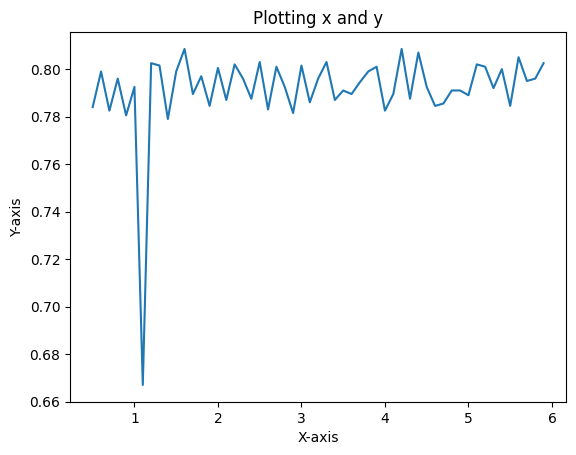

In [1]:
# Imports
import numpy as np
import pandas as pd
# import dcMinMaxFunctions as dc
# import dcor
from scipy.misc import derivative
from sklearn.model_selection import train_test_split
import math
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from opacus.utils.batch_memory_manager import BatchMemoryManager
from opacus import PrivacyEngine

def normalize(x):
    x_normed = x / x.max(0, keepdim=True)[0]
    return x_normed



def OHE(x):
    dim = max(x)
    y = np.zeros((len(x),dim+1))
    for i in range(len(x)):
        y[i][x[i]] = 1
    return(y)
#write a script to load data from data folder and train model


def gau_ker(u):
    return torch.pow(2*torch.tensor(torch.pi),u.shape[1]/(-2))*torch.exp(torch.bmm(u.view(u.shape[0], 1, u.shape[1]), u.view(u.shape[0],  u.shape[1],1))/(-2))
def py_kde(x,X_t,h):
    norm = (X_t.shape[0]*(h**x.shape[1]))
    prob = torch.zeros(x.shape[0]).to(x.device) 
    for i in range(len(X_t)):
        prob+= torch.squeeze(gau_ker((x - X_t[i])/h))/norm
    return(prob)
def py_kde_der(p_x,x):
    # x.requires_grad = True
    # p_x = py_kde(x,X_t,h)
    return (torch.autograd.grad(p_x,x,torch.ones_like(p_x),allow_unused=True,create_graph=True)[0])

# def accuracy(net,X_test,Y_test):
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         outputs = net(X_test)
#         predicted = (outputs > 0.5).float()
#         total += Y_test.size(0)
#         correct += (predicted == Y_test).sum().item()
#     return(100 * correct / total)

def accuracy(preds, labels):
    return (preds == labels).mean()

def train_model(net,trainloader,optimizer,epochs,rate = 10,device= torch.device('cpu'),print_cond = True,privacy_engine = None):
    criterion = nn.BCELoss(reduction= 'none')
    counter =0
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
    
        # data = data.to(device)
        net = net.to(device)
        with BatchMemoryManager(
        data_loader=trainloader, 
        max_physical_batch_size=1000, 
        optimizer=optimizer
    ) as memory_safe_data_loader:
            for i, data in enumerate(trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                
                inputs = data[0].to(device)
                labels = data[1].to(device)
            
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs,labels)
                loss.backward(torch.ones_like(loss))
                optimizer.step()

                # print statistics
                # print(loss.sum().shape)
                running_loss += loss.sum()
                counter+=1
        DELTA = 1e-4
        if (epoch+1) % rate == 0:
            if(privacy_engine != None):
                epsilon = privacy_engine.get_epsilon(DELTA)
            else:
                epsilon = 0
            print(
                f"\tTrain Epoch: {epoch} \t"
                f"Loss: {(running_loss/counter):.6f} "
                # f"Acc@1: {np.mean(top1_acc) * 100:.6f} "
                f"(ε = {epsilon:.2f}, δ = {DELTA})"
                
                )
            counter = 0
            # if i % 100 == 99:    # print every 2000 mini-batches
        # if(epoch%rate==rate-1):
        #     if(print_cond):
        #         print('[%d, %5d] loss: %.10f' %
        #                 (epoch + 1,0, running_loss / 100))
        #         running_loss = 0.0
            # if(privacy_engine != None):
                
            #     eps_val.append(privacy_engine.get_epsilon(delta))
            #     acc.append(accuracy(net,X_test,Y_test))


    print('Finished Training')



def train(model, train_loader, optimizer, epoch, device,privacy_engine = None):
    model.train()
    model.to(device)
    criterion = nn.BCELoss()

    losses = []
    top1_acc = []
    
    with BatchMemoryManager(
        data_loader=train_loader, 
        max_physical_batch_size=1000, 
        optimizer=optimizer
    ) as memory_safe_data_loader:

        for i, (images, target) in enumerate(memory_safe_data_loader):   
            optimizer.zero_grad()
            images = images.to(device)
            target = target.to(device)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            # preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            preds = output.detach().cpu().numpy()
            labels = target.detach().cpu().numpy()
            # print(preds.shape,labels.shape )
            # measure accuracy and record loss
            acc = accuracy(preds, labels)

            losses.append(loss.item())
            # top1_acc.append(acc)

            loss.backward()
            optimizer.step()
            DELTA = 1e-4
    # if (+1) % 10 == 0:
    #     epsilon = privacy_engine.get_epsilon(DELTA)
    #     print(
    #         f"\tTrain Epoch: {epoch} \t"
    #         f"Loss: {np.mean(losses):.6f} "
    #         f"Acc@1: {np.mean(top1_acc) * 100:.6f} "
    #         f"(ε = {epsilon:.2f}, δ = {DELTA})"
    #     )

def test(model, test_loader, device):
    model.to(device)
    model.eval()
    criterion = nn.BCELoss()
    losses = []
    top1_acc = []

    with torch.no_grad():
        for images, target in test_loader:
            images = images.to(device)
            target = target.to(device)

            output = model(images)
            loss = criterion(output, target)
            preds = output.detach().cpu().numpy() > 0.5
            labels = target.detach().cpu().numpy()
            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

    top1_avg = np.mean(top1_acc)

    print(
        f"\tTest set:"
        f"Loss: {np.mean(losses):.6f} "
        f"Acc: {top1_avg * 100:.6f} "
    )
    return np.mean(top1_acc)

def load_data(path):
    df=pd.read_csv("data/Churn_Modelling.csv")
    X = df.loc[:, df.columns != 'Exited'].replace(dict(yes=True, no=False))
    Y = df.loc[:, ['Exited']].replace(dict(yes=True, no=False))
    categorical_columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
    numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
    outputs = ['Exited']
    for category in categorical_columns:
        df[category] = df[category].astype('category')
    geo = OHE(df['Geography'].cat.codes.values)
    gen =  np.asarray(df['Gender'].cat.codes.values)
    hcc =  np.asarray(df['HasCrCard'].cat.codes.values)
    iam =  np.asarray(df['IsActiveMember'].cat.codes.values)

    categorical_data = np.stack(( gen, hcc, iam), axis=1)
    # categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
    numerical_data = np.stack([df[col].values for col in numerical_columns], 1)
    # numerical_data = torch.tensor(numerical_data, dtype=torch.float)
    X = np.concatenate((numerical_data, categorical_data,geo), axis=1)
    Y = df[outputs].values
    # outputs = torch.tensor(df[outputs].values).flatten()
    X = torch.Tensor(X)
    Y = torch.Tensor(Y)
    X = normalize(X)
    return X,Y




def main():
    accs =[]
    import warnings
    warnings.filterwarnings("ignore")
    
    # print(ModuleValidator.validate(model2, strict=False))
    eps_list =np.arange(0.5,6,0.1)
    for target_eps in eps_list:
        X,Y = load_data("data/Churn_Modelling.csv")
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
        
        trainer = torch.utils.data.TensorDataset(X_train,Y_train)
        tester  = torch.utils.data.TensorDataset(X_test,Y_test)

        trainloader = torch.utils.data.DataLoader(trainer, batch_size=1000,
                                                shuffle=True, num_workers=2)
        testloader = torch.utils.data.DataLoader(tester, batch_size=1000,
                                                shuffle=False, num_workers=2)   
    
        
        
        from opacus.validators import ModuleValidator

        
    
        privacy_engine = PrivacyEngine()
        
        # model2 = nn.Sequential(
        #     nn.Linear(12, 32),
        #     nn.ReLU(),
        #     # nn.Linear(48, 32),
        #     # nn.ReLU(),
        #     nn.Linear(32, 1),
        #     nn.Sigmoid(

        #     )
        # )
        # optim2 = torch.optim.Adam(model2.parameters(),lr=0.01,weight_decay=1e-4)

        # train_model(model2,trainloader,optim2,100,10,device=torch.device('cuda'))
        # print(accuracy(model2,X_test.to('cuda'),Y_test.to('cuda')))
        # print(accuracy(model2,X_train.to('cuda'),Y_train.to('cuda')))
        # model2= nn.Sequential(
        #     nn.Linear(12, 32),
        #     nn.ReLU(),
        #     # nn.Linear(48, 32),
        #     # nn.ReLU(),
        #     nn.Linear(32, 1),
        #     nn.Sigmoid(

        #     )
        # )
        
        
        model2= nn.Sequential(
            nn.Linear(12, 32),
            nn.ReLU(),
            # nn.Linear(48, 32),
            # nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid(

            )
        )
        # print(test(model,testloader,torch.device('cuda')))
        # model.train()
        optim = torch.optim.Adam(model2.parameters(),lr=0.01,weight_decay=1e-4)
        model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
            
            module=model2,
            optimizer=optim,
            data_loader=trainloader,
            epochs=1000,
            target_epsilon=target_eps,
            target_delta= 1e-4,
            max_grad_norm=3.0,
        )

        # train_model(model,train_loader,optimizer,100,10,device=torch.device('cuda'),privacy_engine=privacy_engine)
        train(model,train_loader,optimizer,1000,torch.device('cuda'),privacy_engine=privacy_engine)
        # # print(accuracy(model,X_test.to('cuda'),Y_test.to('cuda')))
        # # print(accuracy(model,X_train.to('cuda'),Y_train.to('cuda')))
        accs.append(test(model,testloader,torch.device('cuda')))
        # print(target_eps)
        del(model)
        del(privacy_engine)
        del(optimizer)
        del(train_loader)

    import matplotlib.pyplot as plt

    x = eps_list
    y = accs

    plt.plot(x, y)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Plotting x and y')
    plt.show()   
        # del(test)
# Main body of code. Other functions and class methods are called from main.

# if __name__ == "__main__":
#     main()
main()

In [159]:
data=X


losses= torch.zeros(X.shape[0])
bs = 1000

for ct in range(0,len(X),bs):
    x = data[ct:bs+ct].detach()
    x_hat = autoencoder1(x)
    f = py_kde(x,x,0.5)
    loss =torch.linalg.norm(torch.autograd.grad(f,x,torch.ones_like(f),allow_unused=True,create_graph=True)[0]/f.view(f.shape[0],1)+autoencoder1.loss_reg,dim=1)
    losses[ct:bs+ct] =loss

In [157]:
# with torch.no_grad():
y_pred = autoencoder1(X)
 
accuracy = (y_pred.round() == Y).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.7565365433692932


In [126]:
n=1000
d =12
n**(-1./(d+4))

0.6493816315762113

In [168]:
(losses<3).sum()

tensor(9828)

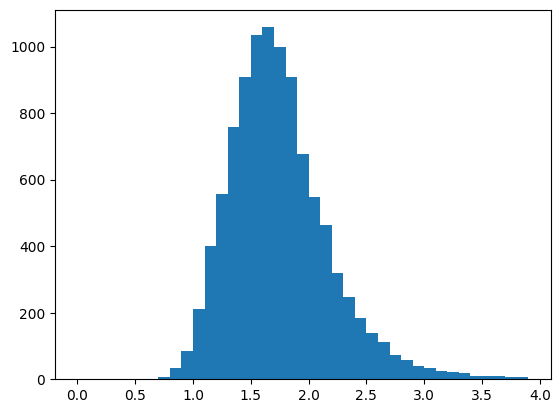

In [174]:

from matplotlib import pyplot as plt
import numpy as np
 
 
# Creating dataset
a = losses.detach()
 
# Creating histogram
fig, ax = plt.subplots()
ax.hist(a, bins = np.arange(0,4,0.1))
 
# Show plot
plt.show()

In [165]:
o = autoencoder1(X_train.detach())
X_emb_train = torch.squeeze(autoencoder1.y).detach()
o = autoencoder1(X_test.detach())
X_emb_test = torch.squeeze(autoencoder1.y).detach()


In [166]:

# o = autoencoder1(X)
# X_embs = torch.squeeze(autoencoder1.y.detach())
model = nn.Sequential(
    nn.Linear(12, 48),
    nn.ReLU(),
    nn.Linear(48, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid(

    )
)
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 1000
batch_size = 1000

for epoch in range(n_epochs):
    for i in range(0, len(X_emb_train), batch_size):
        Xbatch = X_emb_train[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = Y_train[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #     print(loss)
    # print(f'Finished epoch {epoch}, latest loss {loss}')
# compute accuracy (no_grad is optional)
with torch.no_grad():
    y_pred = model(X_emb_test)
 
accuracy = (y_pred.round() == Y_test).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.8335000276565552


In [167]:
model1 = nn.Sequential(
    nn.Linear(12, 48),
    nn.ReLU(),
    nn.Linear(48, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid(

    )
)
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
n_epochs = 1000
batch_size = 1000
 
for epoch in range(n_epochs):
    for i in range(0, len(X_train), batch_size):
        Xbatch = X_train[i:i+batch_size]
        y_pred = model1(Xbatch)
        ybatch = Y_train[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()

with torch.no_grad():
    y_pred = model1(X_test)
 
accuracy = (y_pred.round() == Y_test).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.871999979019165
